# In this notebook, we explore various models and their performance on the dataset

Jack Duryea (jd50), Shashank Mahesh (sm103)


In [1]:
import pathlib
import imageio
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage.color import rgb2gray
from scipy import stats
import glob
import data_utils as du
import cv2
from collections import defaultdict
from skimage.color import rgb2gray
import models
import sklearn
import scipy.stats as stats
from sklearn.metrics import confusion_matrix
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)
    import md5, sha
%matplotlib inline

%load_ext autoreload
%autoreload 2

# Models Selection
We are currently thinking about using the following models:  
Otsu Thresholding   
Spectral clustering 

### Load data

In [2]:
train_image_data = du.get_train_images() 
train_mask_data  = du.get_train_masks()
test_image_data = du.get_test_images()

In [3]:
im1 = train_image_data[0]
m1 = train_mask_data[10]
m2 = train_mask_data[11]

### combine the masks for each image, these are the "Truths"

In [4]:
total_masks = []
for image in train_image_data:
    Big_Mask = du.get_total_mask(image, train_mask_data)
    total_masks.append(Big_Mask)

# Model 1: Naive Thresholding

In [ ]:
# An example of how this model works along with visualization
index = 101
im1 = train_image_data[index]
truth = total_masks[index]
predicted = models.naive_threshold(im1)
plt.imshow(im1.im)
print "Actual Image"
plt.show()
plt.imshow(truth)
print "Actual Nuclei"
plt.show()
plt.imshow(predicted)
print "Predicted Nuclei"
plt.show()


models.score(truth, predicted)

In [ ]:
# Get global score
num_examples = 100
accs = []
for i in range(num_examples):
    im1 = train_image_data[i]
    truth = total_masks[i]
    predicted = models.naive_threshold(im1)
    acc, tn, fp, fn, tp, conf_mat = models.score(truth, predicted)
    accs.append(acc)

In [ ]:
plt.xlabel("Accuracy")
plt.ylabel("Freq")
plt.hist(accs)

### Hyperparamter tuning, change threshold

In [ ]:
thresholds = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
avg_accs = []
for thr in thresholds:
    print "thr:",thr
    num_examples = 30
    accs = []
    for i in range(10, 10+num_examples):
        im1 = train_image_data[i]
        truth = total_masks[i]
        predicted = models.naive_threshold(im1, thr)
        acc, tn, fp, fn, tp, conf_mat = models.score(truth, predicted)
        accs.append(acc)
    avg_acc = np.mean(accs)
    avg_accs.append(avg_acc)

In [ ]:
plt.xlabel("Threshold")
plt.ylabel("Average Accuracy")
plt.plot(thresholds, avg_accs)

### From a small sample, it seems that a threshold of 0.1 works the best, let's scale it up a bit

In [ ]:
len(train_image_data)

In [ ]:
num_examples = 10
accs = []
tps = 0
fps = 0
fns = 0
tns = 0
for i in range(0, num_examples):
    im = train_image_data[i]
    truth = total_masks[i]
    predicted = models.naive_threshold(im, thresh=0.1)
    acc, tn, fp, fn, tp, conf_mat = models.score(truth, predicted)
    accs.append(acc)
    tns += tn
    fps += fp
    fns += fn
    tps += tp


In [ ]:
acc, pre, rec, f1_score = models.get_metrics(tps, fps, tns, fns)


In [ ]:
du.plot_confusion_matrix([[tps,fns],[fps,tns]])

# Model 2: Otsu Thresholding

In [ ]:
num_examples = 10
accs = []
tps = 0
fps = 0
fns = 0
tns = 0
for i in range(0, num_examples):
    im = train_image_data[i]
    truth = total_masks[i]
    predicted = models.otsu_threshold(im)
    acc, tn, fp, fn, tp, conf_mat = models.score(truth, predicted)
    accs.append(acc)
    tns += tn
    fps += fp
    fns += fn
    tps += tp

In [ ]:
acc, pre, rec, f1_score = models.get_metrics(tps, fps, tns, fns)

In [ ]:
du.plot_confusion_matrix([[tps,fns],[fps,tns]])

# Model 3: Slic Thresholding

In [ ]:
num_examples = 10
accs = []
tps = 0
fps = 0
fns = 0
tns = 0
for i in range(0, num_examples):
    im = train_image_data[i]
    truth = total_masks[i]
    predicted = models.random_walk_threshold(im)
    acc, tn, fp, fn, tp, conf_mat = models.score(truth, predicted)
    accs.append(acc)
    tns += tn
    fps += fp
    fns += fn
    tps += tp

In [221]:
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed

In [ ]:
acc, pre, rec, f1_score = models.get_metrics(tps, fps, tns, fns)

In [269]:
img = train_image_data[10].im
bw = rgb2gray(img)

test = models.random_walk_threshold(sub_images[10])

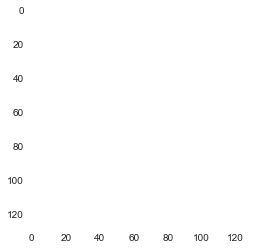

In [270]:
plt.imshow(test)

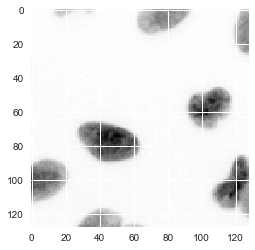

In [337]:
plt.imshow(sub_images[100])

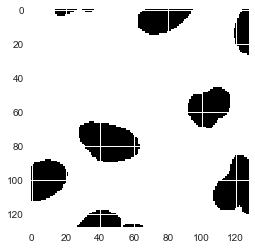

In [336]:
plt.imshow(sub_masks[100])

# Scratch work

In [302]:
sub_images, sub_masks = du.convolve(train_image_data[10],total_masks[10], sample_size=200)

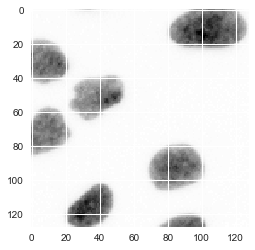

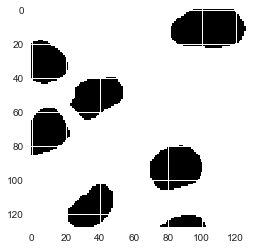

In [332]:
i=4
plt.imshow(sub_images[i])
plt.show()
plt.imshow(sub_masks[i])

In [263]:
# source: https://www.kaggle.com/sjoly123/kerasunet-281

# Neural net model
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from scipy.ndimage.filters import gaussian_laplace

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
import scipy
import tensorflow as tf

# Set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 1

In [264]:
# source: https://www.kaggle.com/sjoly123/kerasunet-281

def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [314]:
# source: https://www.kaggle.com/sjoly123/kerasunet-281
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(8, (1, 1), activation='relu', padding='same') (s)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_5 (InputLayer)             (None, 128, 128, 1)   0                                            
____________________________________________________________________________________________________
lambda_5 (Lambda)                (None, 128, 128, 1)   0           input_5[0][0]                    
____________________________________________________________________________________________________
conv2d_77 (Conv2D)               (None, 128, 128, 8)   16          lambda_5[0][0]                   
____________________________________________________________________________________________________
conv2d_78 (Conv2D)               (None, 128, 128, 8)   584         conv2d_77[0][0]                  
___________________________________________________________________________________________

In [315]:
len(sub_images)

200

In [316]:
X_train = sub_images.reshape(len(sub_images),128,128,1)
y_train = sub_masks.reshape(len(sub_images),128,128,1)

In [324]:
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-1.h5', verbose=1, save_best_only=True)
#results = model.fit(X_train, y_train, validation_split=0.1, batch_size=16, epochs=1, callbacks=[earlystopper, checkpointer])
results = model.fit(X_train, y_train, validation_split=0.1, batch_size=32, epochs=10)

Train on 180 samples, validate on 20 samples
Epoch 1/10
180/180 [==============================] - 11s - loss: 0.2896 - mean_iou: 0.3831 - val_loss: 0.3134 - val_mean_iou: 0.3883
Epoch 2/10
180/180 [==============================] - 11s - loss: 0.2837 - mean_iou: 0.3925 - val_loss: 0.2118 - val_mean_iou: 0.3968
Epoch 3/10
180/180 [==============================] - 11s - loss: 0.2404 - mean_iou: 0.4004 - val_loss: 0.1996 - val_mean_iou: 0.4042
Epoch 4/10
180/180 [==============================] - 11s - loss: 0.2388 - mean_iou: 0.4073 - val_loss: 0.2372 - val_mean_iou: 0.4105
Epoch 5/10
180/180 [==============================] - 11s - loss: 0.2222 - mean_iou: 0.4132 - val_loss: 0.2167 - val_mean_iou: 0.4161
Epoch 6/10
180/180 [==============================] - 11s - loss: 0.2260 - mean_iou: 0.4185 - val_loss: 0.2243 - val_mean_iou: 0.4210
Epoch 7/10
180/180 [==============================] - 11s - loss: 0.2160 - mean_iou: 0.4231 - val_loss: 0.1787 - val_mean_iou: 0.4254
Epoch 8/10
180/18

In [325]:
test1 = model.predict(X_train[10:11])[0].reshape(128,128)

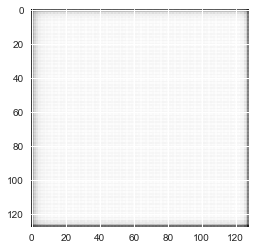

In [326]:
plt.imshow(test1)

In [327]:
sub_masks[10]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)

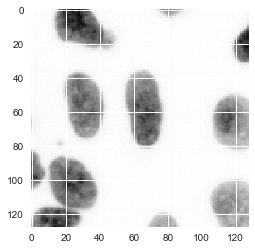

In [328]:
plt.imshow(sub_images[10])

In [ ]:
plt.imshow(Big_Mask,cmap='Greys')

In [ ]:
plt.imshow(im1.im,cmap='Greys')

In [ ]:
plt.imshow(Big_Mask,cmap='Greys')

In [ ]:
plt.imshow(m2.im,cmap='Greys')

In [ ]:
plt.imshow(m2.im + m1.im,cmap='Greys')

In [ ]:
m1.im.shape

In [ ]:
im1.im.shape

In [ ]:
plt.imshow(rgb2gray(im1.im),cmap='Greys')

In [ ]:
"00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552"
im1.dir_id

In [ ]:
mask = models.naive_threshold(im1)

In [ ]:
bw = rgb2gray(im1.im)

In [ ]:
bw2 = np.where(bw>0.1,1,0)

In [ ]:
plt.imshow(mask,cmap='Greys')

In [ ]:
du.encode(bw2)

In [ ]:
test_rle_string = du.rle_to_string(du.encode(bw2))
test_rle_string

In [ ]:
du.rle_decode(test_rle_string,mask.shape, mask.dtype )

In [ ]:
mask

In [ ]:
m = m1.im
m[m > 1] = 1

In [ ]:
stats.describe(mask.flatten())

In [ ]:
m

In [ ]:
mask

In [ ]:
ytrue = np.array([1,0,0])
ypred = np.array([1,1,1])
models.score(m1.im, mask)

In [ ]:
m3 = m2.im + m1.im

In [ ]:
plt.imshow(m3)

In [ ]:
np.count_nonzero(m1.im.flatten())

In [ ]:
np.count_nonzero(m2.im.flatten())

In [ ]:
np.count_nonzero(m3.flatten())

In [ ]:
m3[m3 > 0]=1

In [ ]:
m3

In [ ]:
plt.imshow(m3)

In [ ]:
MASK = du.combine_masks([m1,m2])

In [ ]:
plt.imshow(MASK)